### <span style="color:teal"> __PAIRWISE PERMANOVA ON BRAY-CURTIS DISTANCE BETWEEN HEALTHY AND DISEASE__

In this analysis, we evaluate how gut microbial community composition varies between healthy individuals and various disease conditions using **Bray–Curtis dissimilarity** and **PERMANOVA**. We begin by generating a sample-by-taxon relative abundance matrix at the genus level, then compute pairwise Bray–Curtis distances between all samples. Bray–Curtis is a non-Euclidean distance metric that quantifies dissimilarity between samples based on the proportional abundance of taxa, making it well-suited for ecological data like microbiome profiles.

To assess whether microbial compositions differ significantly between disease states and healthy controls, we perform **pairwise PERMANOVA (Permutational Multivariate Analysis of Variance)**. PERMANOVA is a non-parametric statistical test that evaluates whether the centroids (i.e., multivariate means) of different groups are significantly different based on a distance matrix. Unlike traditional ANOVA, PERMANOVA operates on distances rather than raw values and uses permutations to assess statistical significance. In our case, we test each disease group against the healthy group to determine whether microbial community structure is significantly different. This approach allows us to identify diseases associated with substantial shifts in microbial composition, beyond what would be expected by random variation.


In [5]:
# LOADING PACKAGES
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial import procrustes
import tqdm
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
import os
import multiprocessing
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore", message="The result contains negative eigenvalues.*")


In [6]:
# LOAD BRAY-CURTIS DISATNCE DATA

genus_bc_datamatrix = np.load("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gm_repository/bc_distance_matrix_genus.npy")
species_bc_datamatrix = np.load("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gm_repository/bc_distance_matrix_species.npy")

# LOAD MULTI-INDEX

genus_index = pd.read_pickle("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/braycurtis_genus_index.pkl")
species_index = pd.read_pickle("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/braycurtis_species_index.pkl")

In [7]:
# IMPORT DISEASE DICTIONARY

# Load disease code to name mapping
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_dict.json", "r") as f:
    disease_dict = json.load(f)


#### <span style="color:skyblue"> __PERMANOVA CALCULATION - GENUS LEVEL__

In [8]:
# GENUS LEVEL PERMANOVA RESULTS
# ===============================
# STEP 0: Input Assumptions
# -------------------------------
# You already have:
# - genus_index: a MultiIndex (disease, loaded_uid)
# - genus_bc_datamatrix: a square NumPy array or pd.DataFrame (Bray–Curtis distances)
# ===============================

# ---- Create sample labels for DistanceMatrix ----
genus_labels = genus_index.map(lambda x: f"{x[0]}|{x[1]}")

# ---- Build DistanceMatrix for PERMANOVA ----
genus_dm = DistanceMatrix(genus_bc_datamatrix, ids=genus_labels)

# ---- Build metadata DataFrame ----
genus_metadata = pd.DataFrame(
    genus_index.tolist(),
    columns=["disease", "loaded_uid"],
    index=genus_labels
)

# ---- Initialize parameters ----
healthy_label = "D006262"
n_samples = 30
n_repeats = 10
permanova_results = []

# ---- Loop over each disease ----
for disease in genus_metadata["disease"].unique():
    if disease == healthy_label:
        continue

    healthy_ids = genus_metadata[genus_metadata["disease"] == healthy_label].index.tolist()
    disease_ids = genus_metadata[genus_metadata["disease"] == disease].index.tolist()

    if len(healthy_ids) < n_samples or len(disease_ids) < n_samples:
        continue

    for repeat in range(n_repeats):
        sampled_healthy = np.random.choice(healthy_ids, size=n_samples, replace=False)
        sampled_disease = np.random.choice(disease_ids, size=n_samples, replace=False)

        subset_ids = list(sampled_healthy) + list(sampled_disease)
        subset_dm = genus_dm.filter(subset_ids, strict=False)
        subset_meta = genus_metadata.loc[subset_ids]

        result = permanova(subset_dm, subset_meta["disease"], permutations=999)

        permanova_results.append({
            "Compared With": disease,
            "Repeat": repeat + 1,
            "Pseudo-F": result['test statistic'],
            "p-value": result['p-value']
        })

# ---- Convert to DataFrame and save ----
permanova_df_genus = pd.DataFrame(permanova_results)
permanova_df_genus.to_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_genus.csv", index=False)


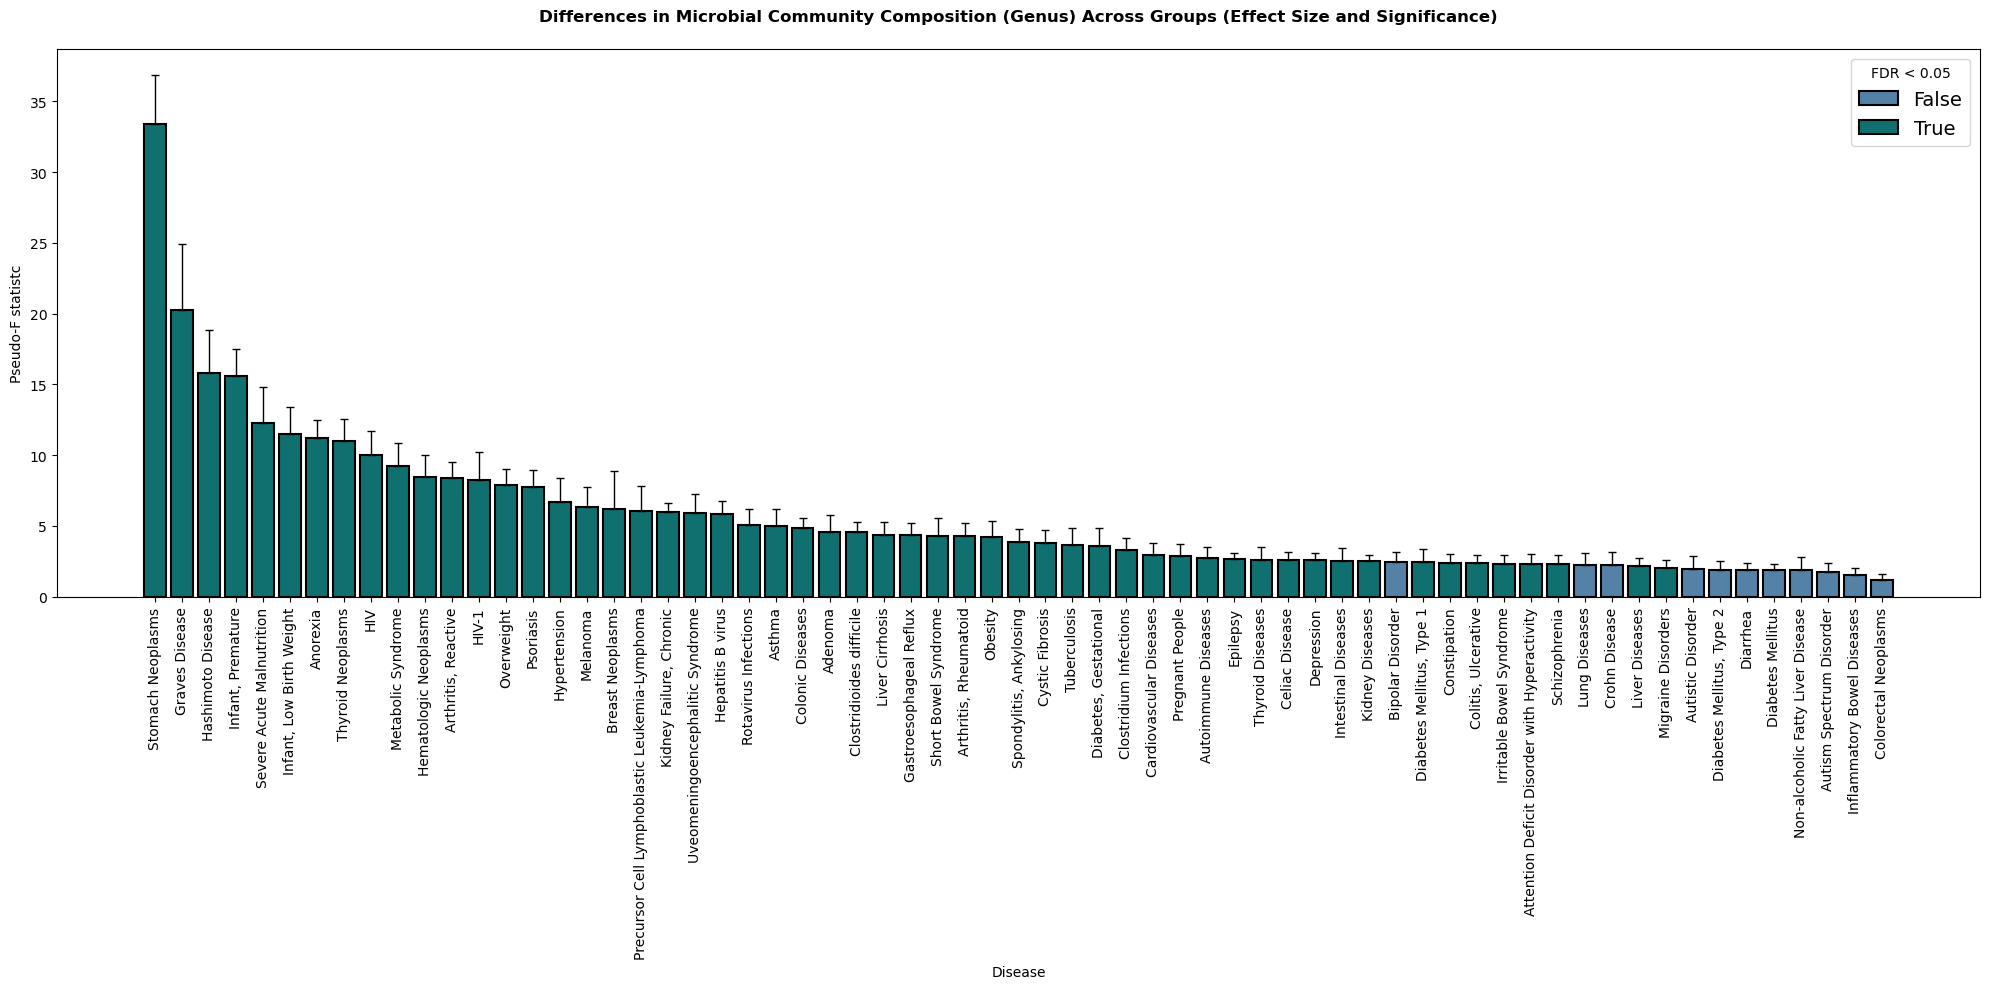

In [9]:
# PLOT THE PERMANOVA RESULTS
# ---- STEP 1: Load saved PERMANOVA results ----
permanova_df_genus = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_genus.csv")

# ---- STEP 2: Aggregate by disease ----
summary_df = (
    permanova_df_genus
    .groupby("Compared With")
    .agg(
        mean_F=('Pseudo-F', 'mean'),
        std_F=('Pseudo-F', 'std'),
        mean_p=('p-value', 'mean'),
        std_p=('p-value', 'std')
    )
    .reset_index()
)

# ---- STEP 3: FDR Correction on mean p-values ----
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_pvals = fdrcorrection(summary_df["mean_p"])
summary_df["FDR-adjusted p-value"] = fdr_pvals
summary_df["Significant (FDR<0.05)"] = summary_df["FDR-adjusted p-value"] < 0.05

# ---- STEP 4: Map disease codes to names using disease_dict ----
# Assumes disease_dict is defined: {'Dxxxxxx': 'Disease Name', ...}
summary_df["Disease Name"] = summary_df["Compared With"].map(disease_dict)
summary_df["Disease Name"] = summary_df["Disease Name"].fillna(summary_df["Compared With"])  # fallback to code

# ---- STEP 5: Plot mean ± SD Pseudo-F (positive error only) ----
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(20, 10))
sorted_df = summary_df.sort_values("mean_F", ascending=False).reset_index(drop=True)

sns.barplot(
    data=sorted_df,
    x="Disease Name",
    y="mean_F",
    hue="Significant (FDR<0.05)",
    dodge=False,
    palette={True: "teal", False: "steelblue"}
)

# Add border around each bar
for patch in plt.gca().patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Add only upper error bars (mean → mean + SD)
plt.errorbar(
    x=np.arange(len(sorted_df)),
    y=sorted_df["mean_F"],
    yerr=[np.zeros(len(sorted_df)), sorted_df["std_F"]],  # asymmetric error bars (lower=0, upper=+SD)
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)

plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Pseudo-F statistc")
plt.title("Differences in Microbial Community Composition (Genus) Across Groups (Effect Size and Significance)", fontweight='bold', pad=20)
plt.tight_layout()
plt.legend(title="FDR < 0.05", loc="upper right", fontsize=14)
plt.show()


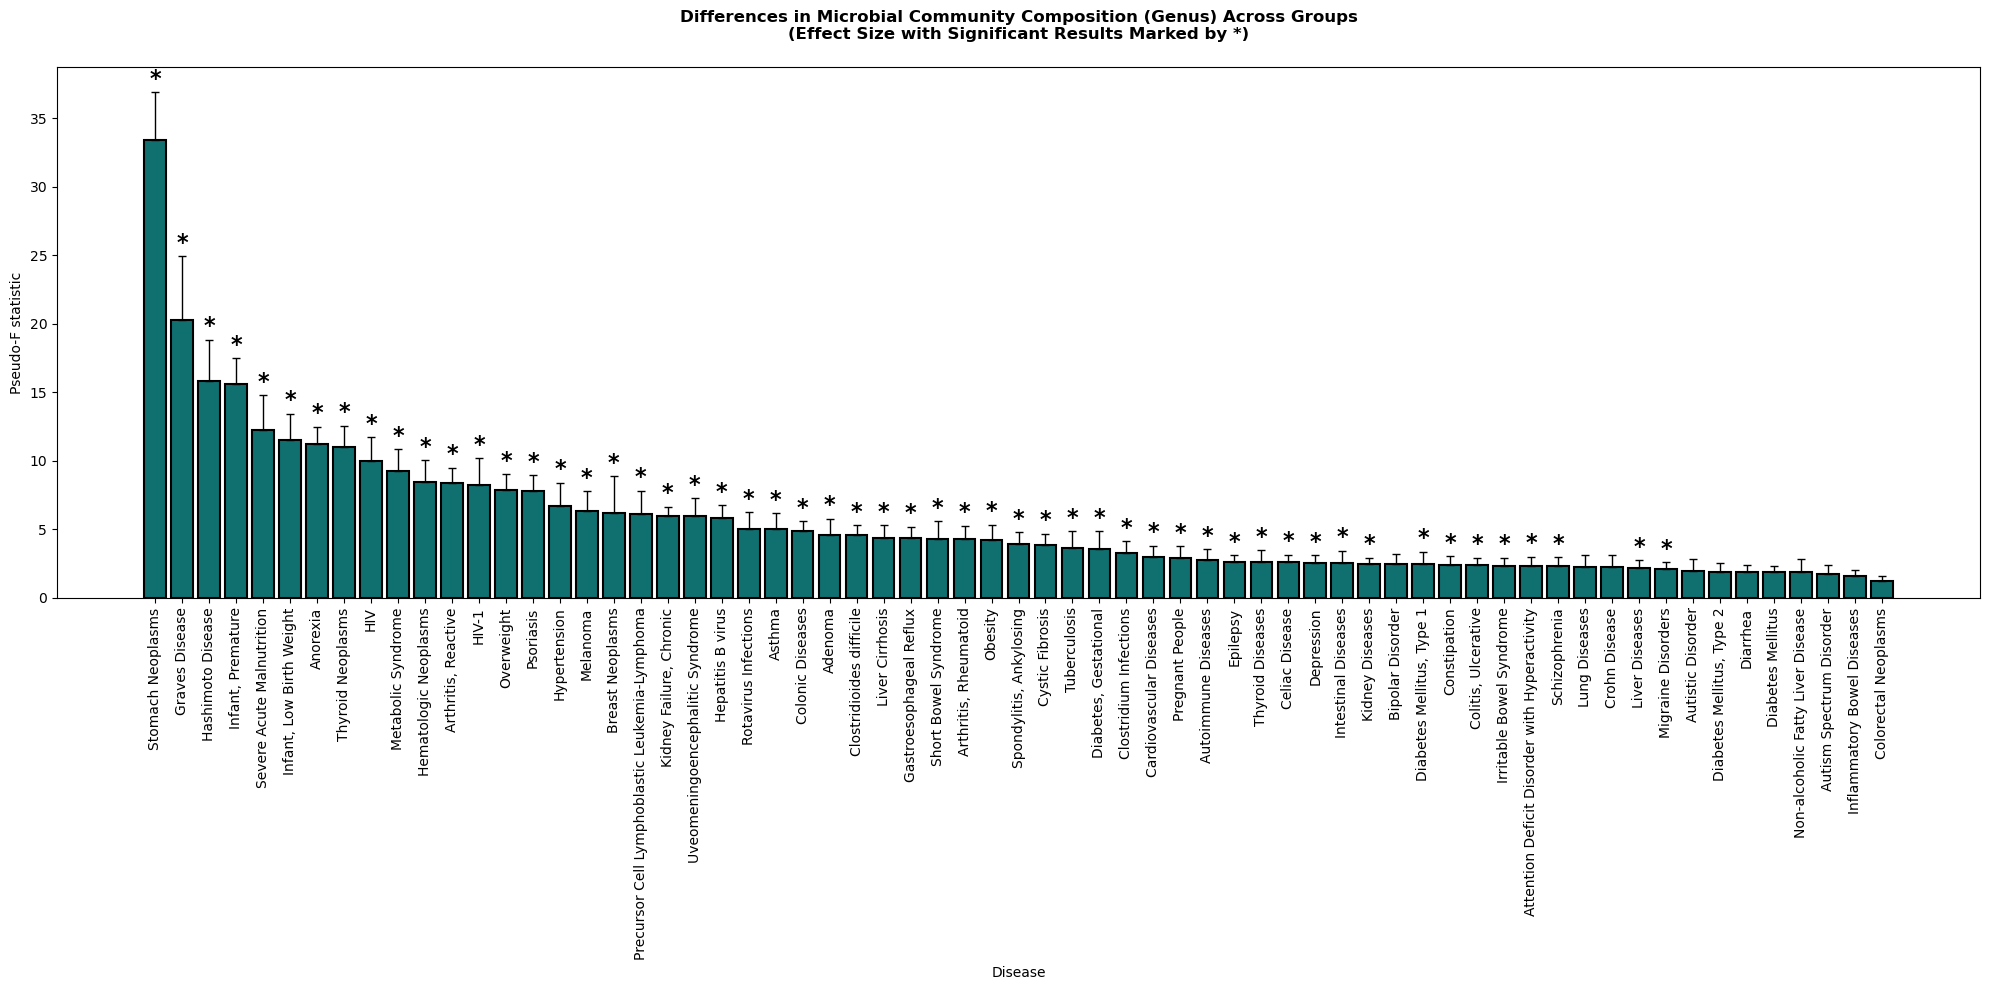

In [10]:
# PLOT THE PERMANOVA RESULTS
# ---- STEP 1: Load saved PERMANOVA results ----
permanova_df_genus = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_genus.csv")

# ---- STEP 2: Aggregate by disease ----
summary_df = (
    permanova_df_genus
    .groupby("Compared With")
    .agg(
        mean_F=('Pseudo-F', 'mean'),
        std_F=('Pseudo-F', 'std'),
        mean_p=('p-value', 'mean'),
        std_p=('p-value', 'std')
    )
    .reset_index()
)

# ---- STEP 3: FDR Correction on mean p-values ----
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_pvals = fdrcorrection(summary_df["mean_p"])
summary_df["FDR-adjusted p-value"] = fdr_pvals
summary_df["Significant (FDR<0.05)"] = summary_df["FDR-adjusted p-value"] < 0.05

# ---- STEP 4: Map disease codes to names using disease_dict ----
# Assumes disease_dict is defined: {'Dxxxxxx': 'Disease Name', ...}
summary_df["Disease Name"] = summary_df["Compared With"].map(disease_dict)
summary_df["Disease Name"] = summary_df["Disease Name"].fillna(summary_df["Compared With"])  # fallback to code

# ---- STEP 5: Plot mean ± SD Pseudo-F (positive error only) ----
plt.figure(figsize=(20, 10))
sorted_df = summary_df.sort_values("mean_F", ascending=False).reset_index(drop=True)

# Single-color barplot
sns.barplot(
    data=sorted_df,
    x="Disease Name",
    y="mean_F",
    color="teal",
    dodge=False
)

# Add border around each bar
for patch in plt.gca().patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Add only upper error bars (mean → mean + SD)
plt.errorbar(
    x=np.arange(len(sorted_df)),
    y=sorted_df["mean_F"],
    yerr=[np.zeros(len(sorted_df)), sorted_df["std_F"]],
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)

# Add asterisks for significant results
for i, row in sorted_df.iterrows():
    if row["Significant (FDR<0.05)"]:
        plt.text(
            i, 
            row["mean_F"] + row["std_F"] + 0.1,  # slightly above error bar
            "*",
            ha='center',
            va='bottom',
            fontsize=16,
            fontweight='bold',
            color='black'
        )

plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Pseudo-F statistic")
plt.title(
    "Differences in Microbial Community Composition (Genus) Across Groups\n(Effect Size with Significant Results Marked by *)",
    fontweight='bold',
    pad=20
)
plt.tight_layout()
plt.show()



#### <span style="color:teal"> __PERMANOVA CALCULATION - SPECIES LEVEL__

In [11]:
# SPECIES LEVEL PERMANOVA RESULTS
# ===============================
# STEP 0: Input Assumptions
# -------------------------------
# You already have:
# - species_index: a MultiIndex (disease, loaded_uid)
# - species_bc_datamatrix: a square NumPy array or pd.DataFrame (Bray–Curtis distances)
# ===============================

# ---- Create sample labels for DistanceMatrix ----
species_labels = species_index.map(lambda x: f"{x[0]}|{x[1]}")

# ---- Build DistanceMatrix for PERMANOVA ----
species_dm = DistanceMatrix(species_bc_datamatrix, ids=species_labels)

# ---- Build metadata DataFrame ----
species_metadata = pd.DataFrame(
    species_index.tolist(),
    columns=["disease", "loaded_uid"],
    index=species_labels
)

# ---- Initialize parameters ----
healthy_label = "D006262"
n_samples = 30
n_repeats = 10
permanova_results = []

# ---- Loop over each disease ----
for disease in species_metadata["disease"].unique():
    if disease == healthy_label:
        continue

    healthy_ids = species_metadata[species_metadata["disease"] == healthy_label].index.tolist()
    disease_ids = species_metadata[species_metadata["disease"] == disease].index.tolist()

    if len(healthy_ids) < n_samples or len(disease_ids) < n_samples:
        continue

    for repeat in range(n_repeats):
        sampled_healthy = np.random.choice(healthy_ids, size=n_samples, replace=False)
        sampled_disease = np.random.choice(disease_ids, size=n_samples, replace=False)

        subset_ids = list(sampled_healthy) + list(sampled_disease)
        subset_dm = species_dm.filter(subset_ids, strict=False)
        subset_meta = species_metadata.loc[subset_ids]

        result = permanova(subset_dm, subset_meta["disease"], permutations=999)

        permanova_results.append({
            "Compared With": disease,
            "Repeat": repeat + 1,
            "Pseudo-F": result['test statistic'],
            "p-value": result['p-value']
        })

# ---- Convert to DataFrame and save ----
permanova_df_species = pd.DataFrame(permanova_results)
permanova_df_species.to_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_species.csv", index=False)


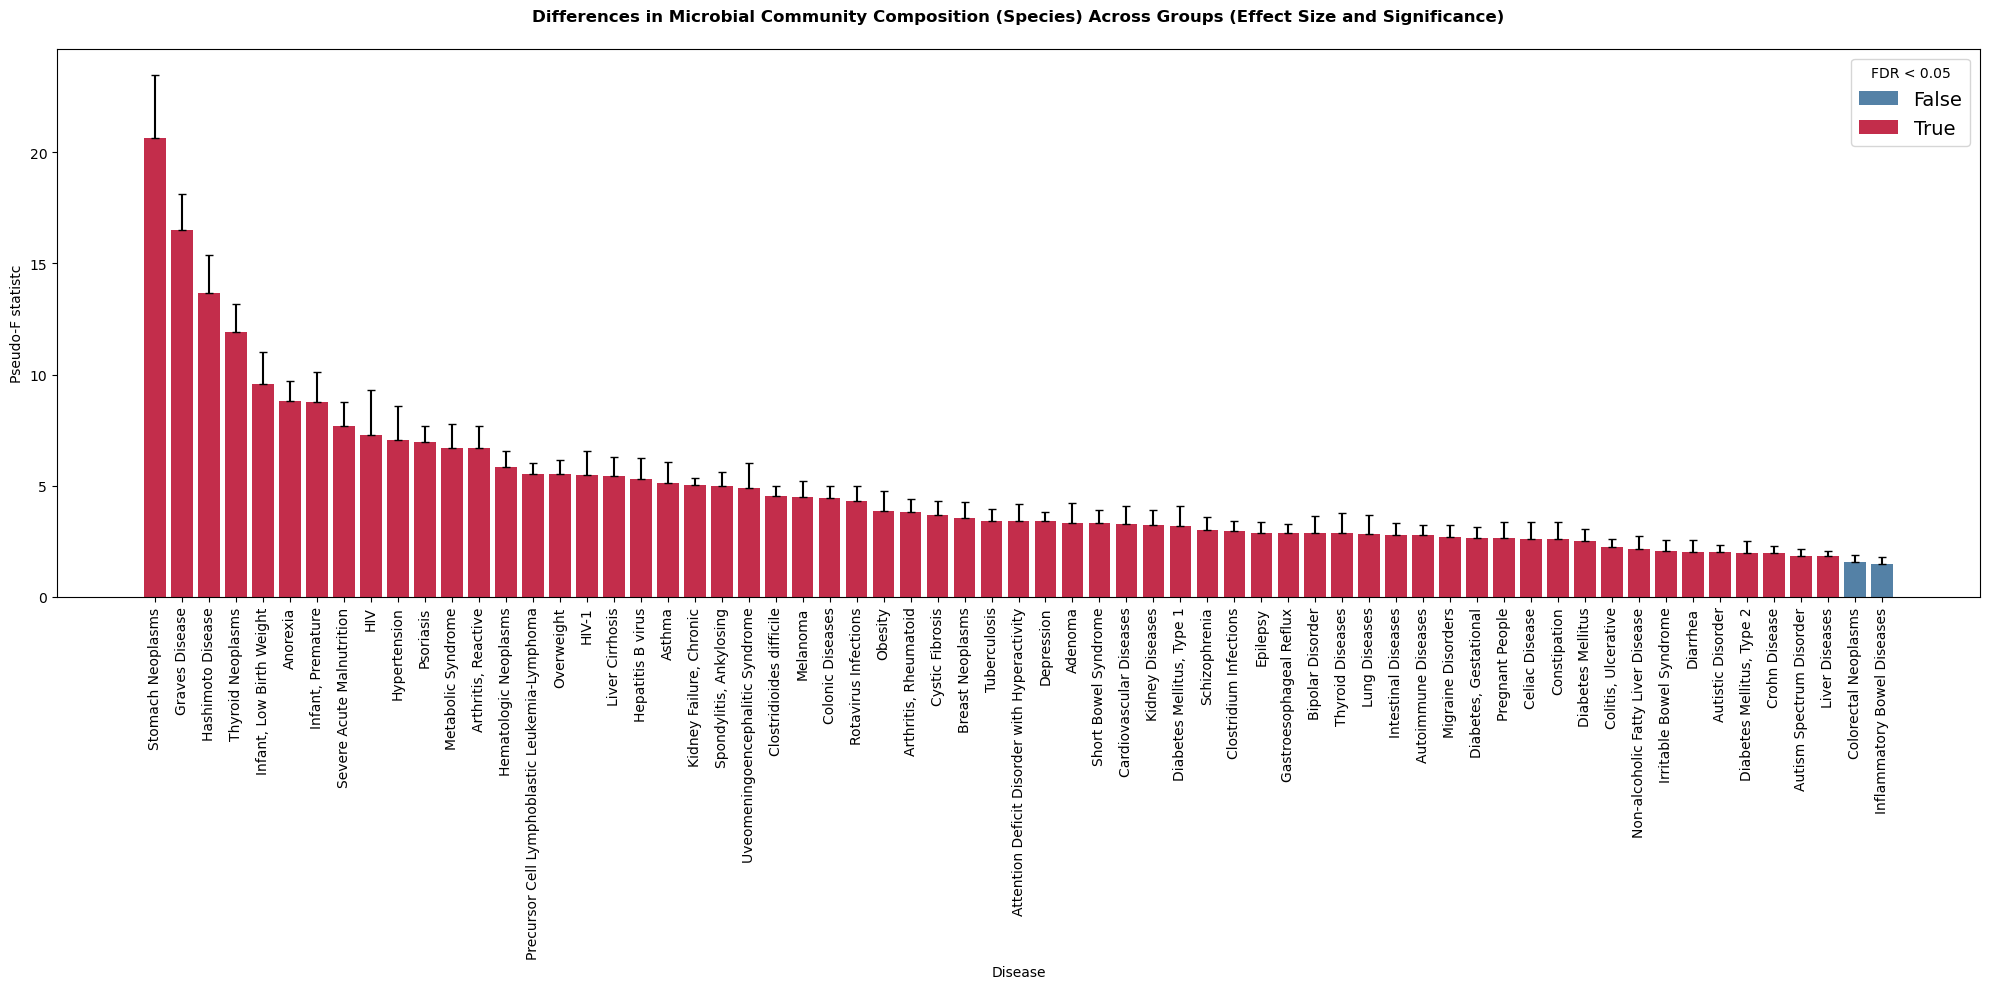

In [12]:
# PLOT THE PERMANOVA RESULTS
# ---- STEP 1: Load saved PERMANOVA results ----
permanova_df_species = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_species.csv")

# ---- STEP 2: Aggregate by disease ----
summary_df = (
    permanova_df_species
    .groupby("Compared With")
    .agg(
        mean_F=('Pseudo-F', 'mean'),
        std_F=('Pseudo-F', 'std'),
        mean_p=('p-value', 'mean'),
        std_p=('p-value', 'std')
    )
    .reset_index()
)

# ---- STEP 3: FDR Correction on mean p-values ----
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_pvals = fdrcorrection(summary_df["mean_p"])
summary_df["FDR-adjusted p-value"] = fdr_pvals
summary_df["Significant (FDR<0.05)"] = summary_df["FDR-adjusted p-value"] < 0.05

# ---- STEP 4: Map disease codes to names using disease_dict ----
# Assumes disease_dict is defined: {'Dxxxxxx': 'Disease Name', ...}
summary_df["Disease Name"] = summary_df["Compared With"].map(disease_dict)
summary_df["Disease Name"] = summary_df["Disease Name"].fillna(summary_df["Compared With"])  # fallback to code

# ---- STEP 5: Plot mean ± SD Pseudo-F (positive error only) ----
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(20, 10))
sorted_df = summary_df.sort_values("mean_F", ascending=False).reset_index(drop=True)

sns.barplot(
    data=sorted_df,
    x="Disease Name",
    y="mean_F",
    hue="Significant (FDR<0.05)",
    dodge=False,
    palette={True: "crimson", False: "steelblue"}
)

# Add only upper error bars (mean → mean + SD)
plt.errorbar(
    x=np.arange(len(sorted_df)),
    y=sorted_df["mean_F"],
    yerr=[np.zeros(len(sorted_df)), sorted_df["std_F"]],  # asymmetric error bars (lower=0, upper=+SD)
    fmt='none',
    capsize=3,
    color='black'
)

plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Pseudo-F statistc")
plt.title("Differences in Microbial Community Composition (Species) Across Groups (Effect Size and Significance)", fontweight='bold', pad=20)
plt.tight_layout()
plt.legend(title="FDR < 0.05", loc="upper right", fontsize=14)
plt.show()


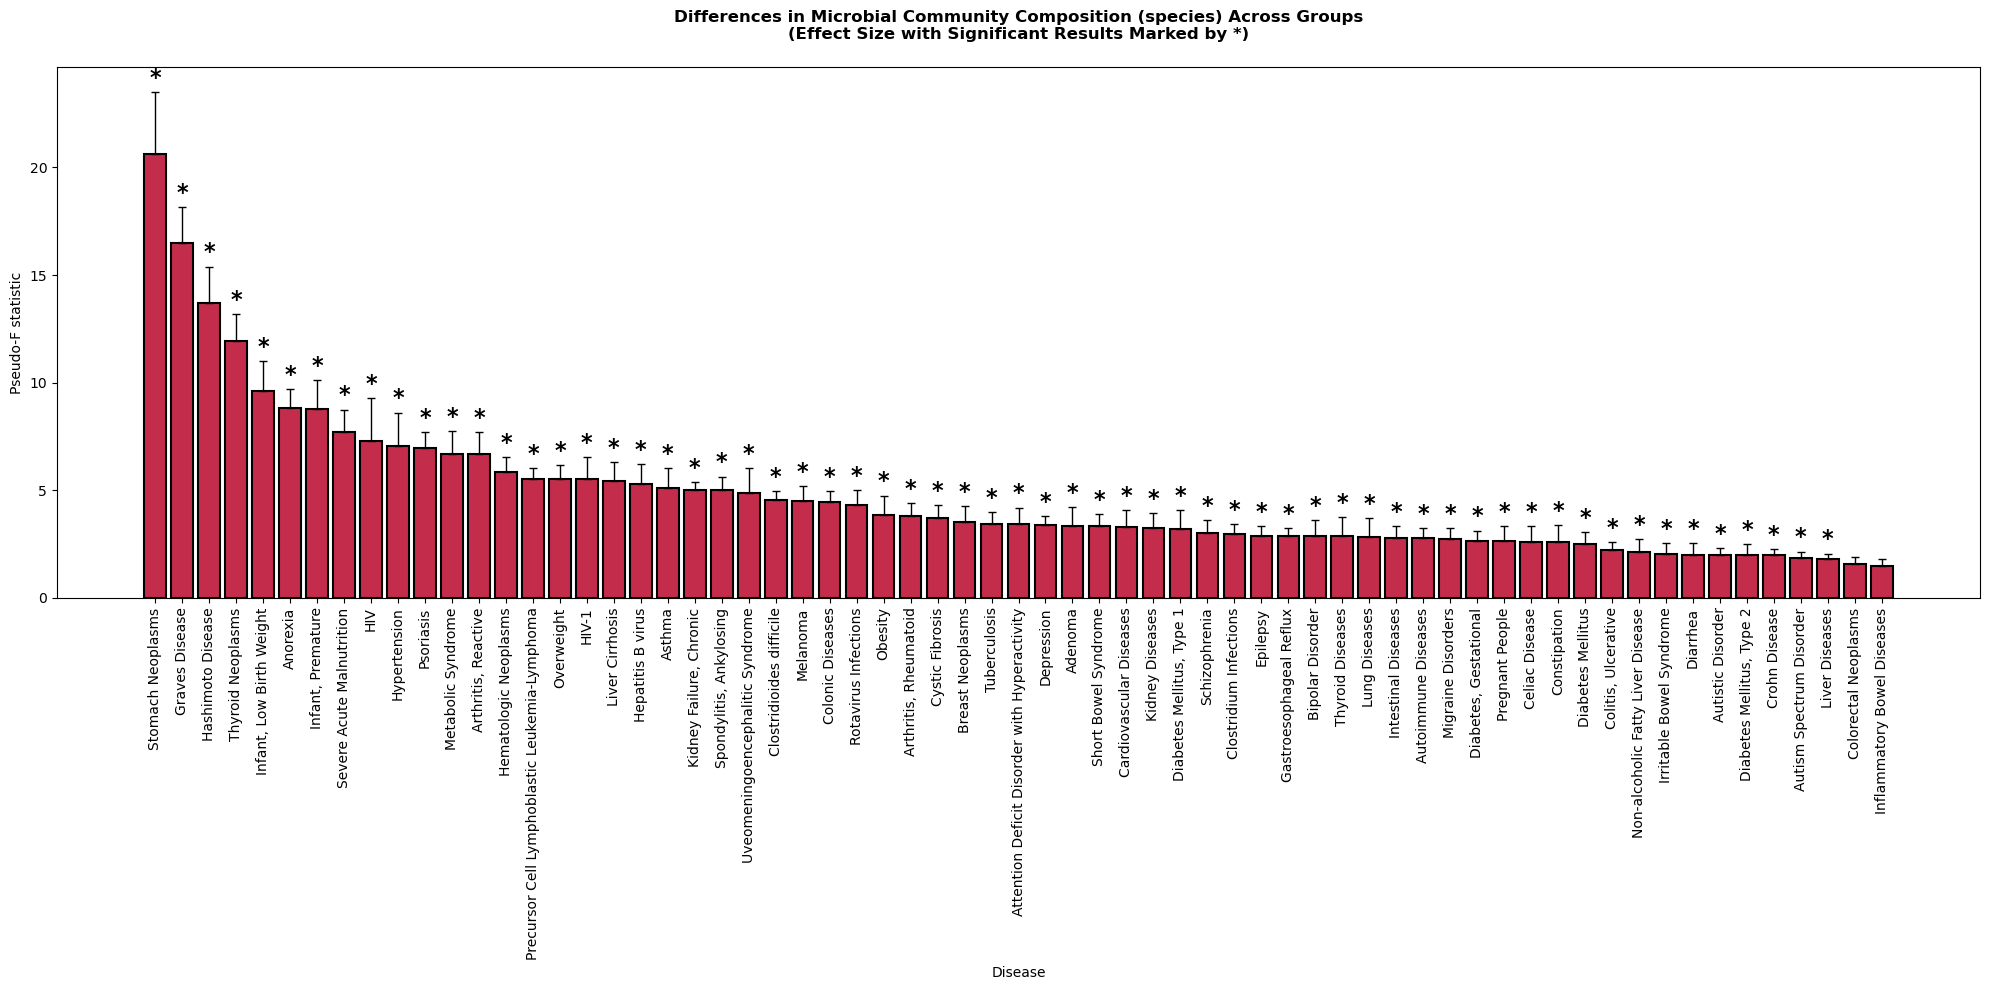

In [13]:
# PLOT THE PERMANOVA RESULTS
# ---- STEP 1: Load saved PERMANOVA results ----
permanova_df_species = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_species.csv")

# ---- STEP 2: Aggregate by disease ----
summary_df = (
    permanova_df_species
    .groupby("Compared With")
    .agg(
        mean_F=('Pseudo-F', 'mean'),
        std_F=('Pseudo-F', 'std'),
        mean_p=('p-value', 'mean'),
        std_p=('p-value', 'std')
    )
    .reset_index()
)

# ---- STEP 3: FDR Correction on mean p-values ----
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_pvals = fdrcorrection(summary_df["mean_p"])
summary_df["FDR-adjusted p-value"] = fdr_pvals
summary_df["Significant (FDR<0.05)"] = summary_df["FDR-adjusted p-value"] < 0.05

# ---- STEP 4: Map disease codes to names using disease_dict ----
# Assumes disease_dict is defined: {'Dxxxxxx': 'Disease Name', ...}
summary_df["Disease Name"] = summary_df["Compared With"].map(disease_dict)
summary_df["Disease Name"] = summary_df["Disease Name"].fillna(summary_df["Compared With"])  # fallback to code

# ---- STEP 5: Plot mean ± SD Pseudo-F (positive error only) ----
plt.figure(figsize=(20, 10))
sorted_df = summary_df.sort_values("mean_F", ascending=False).reset_index(drop=True)

# Single-color barplot
sns.barplot(
    data=sorted_df,
    x="Disease Name",
    y="mean_F",
    color="crimson",
    dodge=False
)

# Add border around each bar
for patch in plt.gca().patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Add only upper error bars (mean → mean + SD)
plt.errorbar(
    x=np.arange(len(sorted_df)),
    y=sorted_df["mean_F"],
    yerr=[np.zeros(len(sorted_df)), sorted_df["std_F"]],
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)

# Add asterisks for significant results
for i, row in sorted_df.iterrows():
    if row["Significant (FDR<0.05)"]:
        plt.text(
            i, 
            row["mean_F"] + row["std_F"] + 0.1,  # slightly above error bar
            "*",
            ha='center',
            va='bottom',
            fontsize=16,
            fontweight='bold',
            color='black'
        )

plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Pseudo-F statistic")
plt.title(
    "Differences in Microbial Community Composition (species) Across Groups\n(Effect Size with Significant Results Marked by *)",
    fontweight='bold',
    pad=20
)
plt.tight_layout()
plt.show()



___
___
___

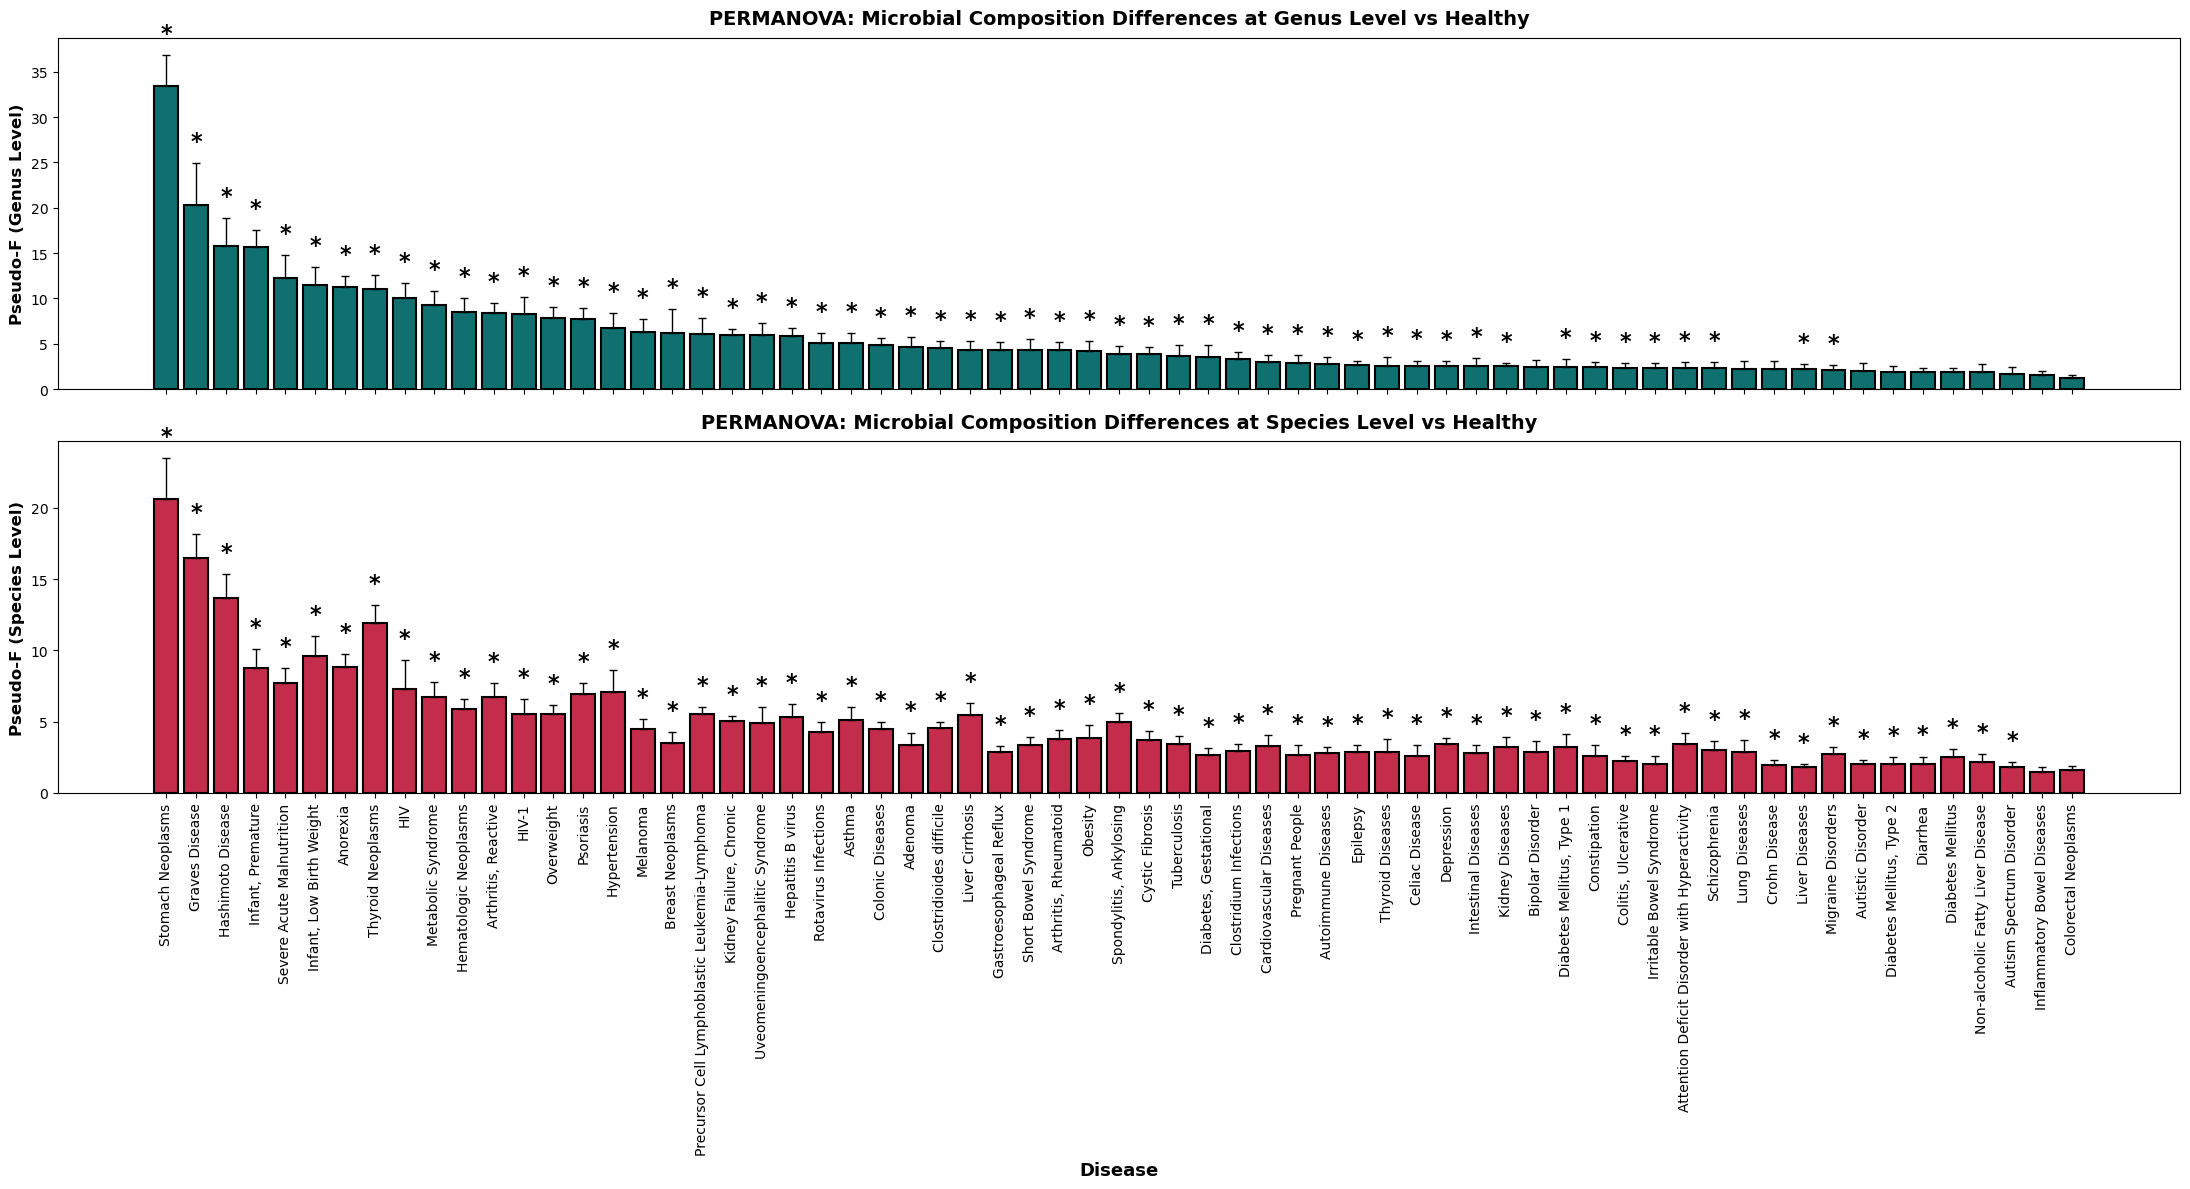

In [14]:
# Combined plot - stcaked
# ----------------------------------------------
# STEP 1: Load genus and species PERMANOVA files
# ----------------------------------------------
permanova_df_genus = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_genus.csv")
permanova_df_species = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_species.csv")

# ----------------------------------------------
# STEP 2: Define a summary function
# ----------------------------------------------
def summarize_permanova(df, disease_dict):
    summary_df = (
        df.groupby("Compared With")
        .agg(
            mean_F=('Pseudo-F', 'mean'),
            std_F=('Pseudo-F', 'std'),
            mean_p=('p-value', 'mean'),
            std_p=('p-value', 'std')
        )
        .reset_index()
    )
    rej, fdr_pvals = fdrcorrection(summary_df["mean_p"])
    summary_df["FDR-adjusted p-value"] = fdr_pvals
    summary_df["Significant (FDR<0.05)"] = summary_df["FDR-adjusted p-value"] < 0.05
    summary_df["Disease Name"] = summary_df["Compared With"].map(disease_dict)
    summary_df["Disease Name"] = summary_df["Disease Name"].fillna(summary_df["Compared With"])
    return summary_df

# ----------------------------------------------
# STEP 3: Summarize both levels
# ----------------------------------------------
summary_genus = summarize_permanova(permanova_df_genus, disease_dict)
summary_species = summarize_permanova(permanova_df_species, disease_dict)

# ----------------------------------------------
# STEP 4: Sort diseases by genus-level mean_F
# ----------------------------------------------
ordered_names = (
    summary_genus.sort_values("mean_F", ascending=False)["Disease Name"]
    .tolist()
)

# Apply ordering
summary_genus["Disease Name"] = pd.Categorical(summary_genus["Disease Name"], categories=ordered_names, ordered=True)
summary_species["Disease Name"] = pd.Categorical(summary_species["Disease Name"], categories=ordered_names, ordered=True)

summary_genus = summary_genus.sort_values("Disease Name")
summary_species = summary_species.sort_values("Disease Name")

# ----------------------------------------------
# STEP 5: Plot stacked plots (genus on top) — single color + asterisks for significance
# ----------------------------------------------

# Ensure sequential indices for alignment with np.arange
summary_genus  = summary_genus.sort_values("Disease Name").reset_index(drop=True)
summary_species = summary_species.sort_values("Disease Name").reset_index(drop=True)

fig, axes = plt.subplots(2, 1, figsize=(22, 12), sharex=True)

# Helper to add borders to bars
def add_bar_borders(ax):
    for p in ax.patches:
        p.set_edgecolor('black')
        p.set_linewidth(1.5)

# Helper to place asterisks above error bars
def add_signif_asterisks(ax, df, y_pad_frac=0.03):
    # y position padding relative to data range
    top_vals = np.nan_to_num(df["mean_F"]) + np.nan_to_num(df["std_F"])
    y_pad = (top_vals.max() if len(top_vals) else 1.0) * y_pad_frac
    for i, row in df.iterrows():
        if row["Significant (FDR<0.05)"]:
            y_top = (row["mean_F"] if pd.notnull(row["mean_F"]) else 0.0) + \
                    (row["std_F"] if pd.notnull(row["std_F"]) else 0.0)
            ax.text(
                i, y_top + y_pad, "*",
                ha="center", va="bottom",
                fontsize=16, fontweight="bold", color="black"
            )

# === GENUS (TOP) ===
sns.barplot(
    data=summary_genus,
    x="Disease Name",
    y="mean_F",
    color="teal",
    dodge=False,
    ax=axes[0],
)
add_bar_borders(axes[0])
axes[0].errorbar(
    x=np.arange(len(summary_genus)),
    y=summary_genus["mean_F"],
    yerr=[np.zeros(len(summary_genus)), np.nan_to_num(summary_genus["std_F"])],
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)
add_signif_asterisks(axes[0], summary_genus)
axes[0].set_ylabel("Pseudo-F (Genus Level)", fontsize=12, weight='bold')
axes[0].set_title("PERMANOVA: Microbial Composition Differences at Genus Level vs Healthy",
                  fontsize=14, weight='bold', pad=10)
axes[0].legend_.remove() if axes[0].get_legend() else None  # no legend

# === SPECIES (BOTTOM) ===
sns.barplot(
    data=summary_species,
    x="Disease Name",
    y="mean_F",
    color="crimson",
    dodge=False,
    ax=axes[1],
)
add_bar_borders(axes[1])
axes[1].errorbar(
    x=np.arange(len(summary_species)),
    y=summary_species["mean_F"],
    yerr=[np.zeros(len(summary_species)), np.nan_to_num(summary_species["std_F"])],
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)
add_signif_asterisks(axes[1], summary_species)
axes[1].set_ylabel("Pseudo-F (Species Level)", fontsize=12, weight='bold')
axes[1].set_title("PERMANOVA: Microbial Composition Differences at Species Level vs Healthy",
                  fontsize=14, weight='bold', pad=10)
axes[1].set_xticks(np.arange(len(ordered_names)))
axes[1].set_xticklabels(ordered_names, rotation=90)
axes[1].set_xlabel("Disease", fontsize=13, weight='bold')
axes[1].legend_.remove() if axes[1].get_legend() else None  # no legend

plt.tight_layout()
plt.show()


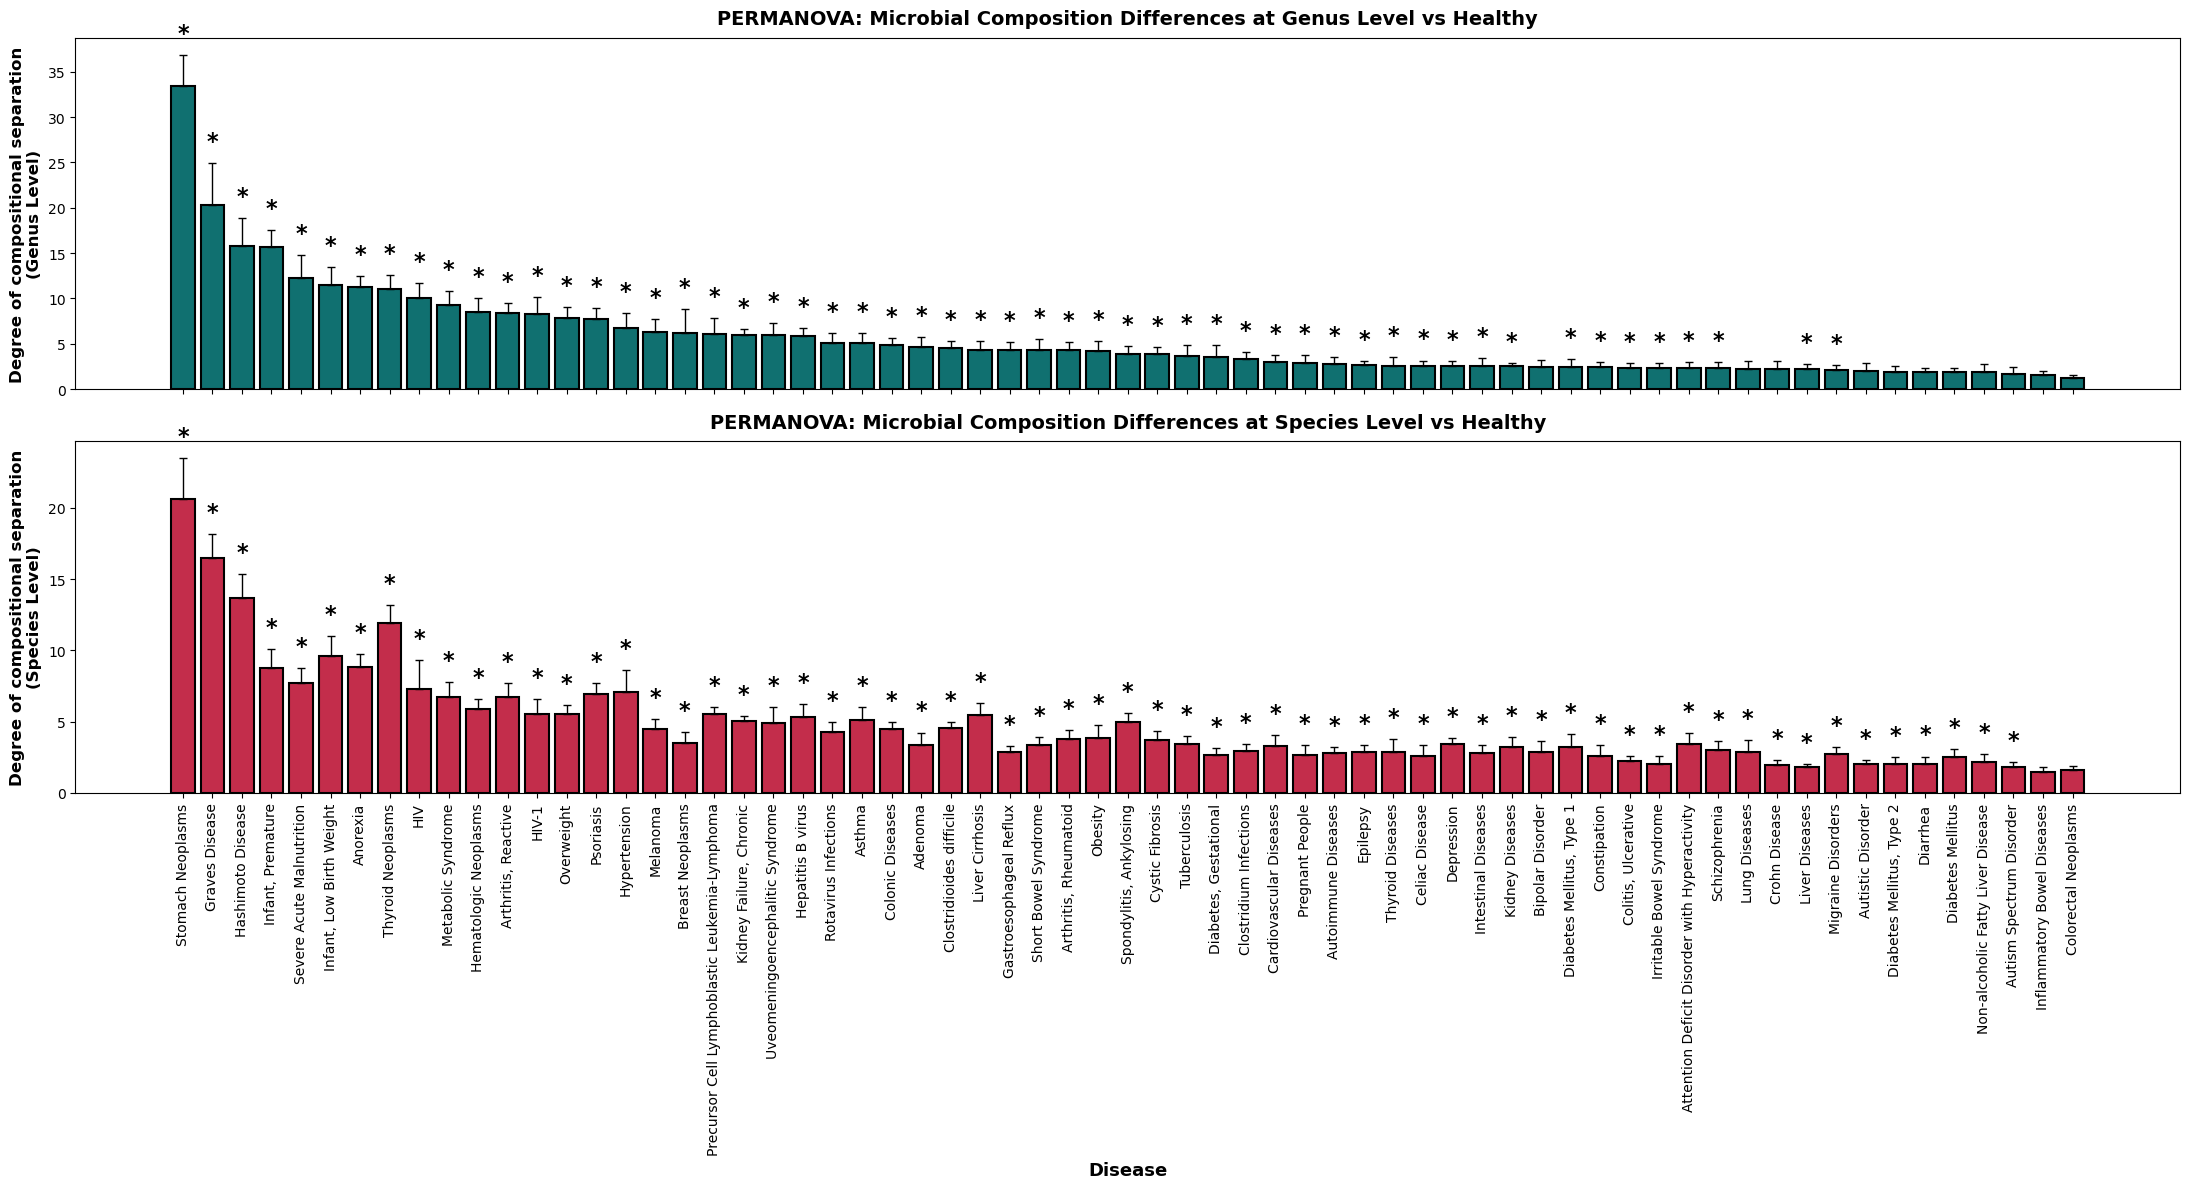

In [15]:
# Combined plot - stcaked
# ----------------------------------------------
# STEP 1: Load genus and species PERMANOVA files
# ----------------------------------------------
permanova_df_genus = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_genus.csv")
permanova_df_species = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/permanova_results_species.csv")

# ----------------------------------------------
# STEP 2: Define a summary function
# ----------------------------------------------
def summarize_permanova(df, disease_dict):
    summary_df = (
        df.groupby("Compared With")
        .agg(
            mean_F=('Pseudo-F', 'mean'),
            std_F=('Pseudo-F', 'std'),
            mean_p=('p-value', 'mean'),
            std_p=('p-value', 'std')
        )
        .reset_index()
    )
    rej, fdr_pvals = fdrcorrection(summary_df["mean_p"])
    summary_df["FDR-adjusted p-value"] = fdr_pvals
    summary_df["Significant (FDR<0.05)"] = summary_df["FDR-adjusted p-value"] < 0.05
    summary_df["Disease Name"] = summary_df["Compared With"].map(disease_dict)
    summary_df["Disease Name"] = summary_df["Disease Name"].fillna(summary_df["Compared With"])
    return summary_df

# ----------------------------------------------
# STEP 3: Summarize both levels
# ----------------------------------------------
summary_genus = summarize_permanova(permanova_df_genus, disease_dict)
summary_species = summarize_permanova(permanova_df_species, disease_dict)

# ----------------------------------------------
# STEP 4: Sort diseases by genus-level mean_F
# ----------------------------------------------
ordered_names = (
    summary_genus.sort_values("mean_F", ascending=False)["Disease Name"]
    .tolist()
)

# Apply ordering
summary_genus["Disease Name"] = pd.Categorical(summary_genus["Disease Name"], categories=ordered_names, ordered=True)
summary_species["Disease Name"] = pd.Categorical(summary_species["Disease Name"], categories=ordered_names, ordered=True)

summary_genus = summary_genus.sort_values("Disease Name")
summary_species = summary_species.sort_values("Disease Name")

# ----------------------------------------------
# STEP 5: Plot stacked plots (genus on top) — single color + asterisks for significance
# ----------------------------------------------

# Ensure sequential indices for alignment with np.arange
summary_genus  = summary_genus.sort_values("Disease Name").reset_index(drop=True)
summary_species = summary_species.sort_values("Disease Name").reset_index(drop=True)

fig, axes = plt.subplots(2, 1, figsize=(22, 12), sharex=True)

# Helper to add borders to bars
def add_bar_borders(ax):
    for p in ax.patches:
        p.set_edgecolor('black')
        p.set_linewidth(1.5)

# Helper to place asterisks above error bars
def add_signif_asterisks(ax, df, y_pad_frac=0.03):
    # y position padding relative to data range
    top_vals = np.nan_to_num(df["mean_F"]) + np.nan_to_num(df["std_F"])
    y_pad = (top_vals.max() if len(top_vals) else 1.0) * y_pad_frac
    for i, row in df.iterrows():
        if row["Significant (FDR<0.05)"]:
            y_top = (row["mean_F"] if pd.notnull(row["mean_F"]) else 0.0) + \
                    (row["std_F"] if pd.notnull(row["std_F"]) else 0.0)
            ax.text(
                i, y_top + y_pad, "*",
                ha="center", va="bottom",
                fontsize=16, fontweight="bold", color="black"
            )

# === GENUS (TOP) ===
sns.barplot(
    data=summary_genus,
    x="Disease Name",
    y="mean_F",
    color="teal",
    dodge=False,
    ax=axes[0],
)
add_bar_borders(axes[0])
axes[0].errorbar(
    x=np.arange(len(summary_genus)),
    y=summary_genus["mean_F"],
    yerr=[np.zeros(len(summary_genus)), np.nan_to_num(summary_genus["std_F"])],
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)
add_signif_asterisks(axes[0], summary_genus)
axes[0].set_ylabel("Degree of compositional separation\n(Genus Level)", fontsize=12, weight='bold')
axes[0].set_title("PERMANOVA: Microbial Composition Differences at Genus Level vs Healthy",
                  fontsize=14, weight='bold', pad=10)
axes[0].legend_.remove() if axes[0].get_legend() else None  # no legend

# === SPECIES (BOTTOM) ===
sns.barplot(
    data=summary_species,
    x="Disease Name",
    y="mean_F",
    color="crimson",
    dodge=False,
    ax=axes[1],
)
add_bar_borders(axes[1])
axes[1].errorbar(
    x=np.arange(len(summary_species)),
    y=summary_species["mean_F"],
    yerr=[np.zeros(len(summary_species)), np.nan_to_num(summary_species["std_F"])],
    fmt='none',
    capsize=3,
    color='black',
    linewidth=1
)
add_signif_asterisks(axes[1], summary_species)
axes[1].set_ylabel("Degree of compositional separation\n(Species Level)", fontsize=12, weight='bold')
axes[1].set_title("PERMANOVA: Microbial Composition Differences at Species Level vs Healthy",
                  fontsize=14, weight='bold', pad=10)
axes[1].set_xticks(np.arange(len(ordered_names)))
axes[1].set_xticklabels(ordered_names, rotation=90)
axes[1].set_xlabel("Disease", fontsize=13, weight='bold')
axes[1].legend_.remove() if axes[1].get_legend() else None  # no legend

plt.tight_layout()
plt.show()
